Avant de lancer ce NB, je lance le terminal Anaconda et je copie colle : 
mlflow server --host 127.0.0.1 --port 8080 

Ca lance MLFlow

In [27]:
import mlflow
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, fbeta_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler


from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import lightgbm as lgb

from mlflow.models import infer_signature
from lightgbm import early_stopping

import shap
# Memory management
import gc 

In [51]:
# démarrage du tracking
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

In [52]:
# Vérifiez que le serveur MLflow est accessible
try:
    mlflow.get_experiment_by_name("MLflow Credit_Scoring - Projet_7")
    print("Le serveur MLflow est accessible.")
except Exception as e:
    print(f"Erreur de connexion au serveur MLflow: {e}")

Le serveur MLflow est accessible.


# 7 - Nouvelle modélisation sur la sélection de features 
--------

In [28]:
train_reduced=pd.read_csv('train_reduced.csv')

In [29]:
train_reduced.head()

,EXT_SOURCE_1,CREDIT_TERM,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,client_installments_AMT_PAYMENT_min_sum,AMT_ANNUITY,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,...,client_installments_NUM_INSTALMENT_NUMBER_min_max,ORGANIZATION_TYPE_Business Entity Type 3,previous_NAME_CASH_LOAN_PURPOSE_XNA_sum,previous_CODE_REJECT_REASON_LIMIT_mean,previous_NAME_SELLER_INDUSTRY_Construction_mean,FLAG_DOCUMENT_16,NAME_INCOME_TYPE_Working,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,TARGET,SK_ID_CURR
0,0.083037,0.060749,0.262949,0.139376,9461,-637.0,175783.73,24700.5,-103.0,780.0,...,1.0,True,0.0,0.000000,0.000000,0,True,0.0,1,100002
1,0.311267,0.027598,0.622246,NaN,16765,-1188.0,1154108.20,35698.5,-606.0,1216.0,...,1.0,False,1.0,0.000000,0.000000,0,False,0.0,0,100003
2,NaN,0.050000,0.555912,0.729567,19046,-225.0,16071.75,6750.0,-408.0,-382.0,...,1.0,False,0.0,0.000000,0.000000,0,True,0.0,0,100004
3,NaN,0.094941,0.650442,NaN,19005,-3039.0,994476.70,29686.5,NaN,NaN,...,1.0,True,5.0,0.111111,0.111111,0,True,0.0,0,100006
4,NaN,0.042623,0.322738,NaN,19932,-3038.0,483756.38,21865.5,-1149.0,-783.0,...,1.0,False,4.0,0.000000,0.000000,0,True,0.0,0,100007


In [30]:
train_reduced.shape

(307511, 346)

In [31]:
def prepare_modelisation (full_train) :

    # split train/test
    train, test = train_test_split(full_train, test_size=0.2, random_state=42)

    # Extraire les identifiants, les cibles et les caractéristiques pour les ensembles d'entraînement et de test
    X_train = train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    y_train = train['TARGET']
    id_train = train['SK_ID_CURR']

    X_test = test.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    y_test = test['TARGET']
    id_test = test['SK_ID_CURR']
    
    # Create a label encoder object
    le = LabelEncoder()
    
    # Iterate through the columns and label encode if object type and nunique <=2
    for col in X_train.columns:
        if X_train[col].dtype == 'object' and len(list(X_train[col].unique())) <= 2:
            # Apply the label encoder to both training and test sets
            X_train[col] = le.fit_transform(X_train[col])
            X_test[col] = le.transform(X_test[col])

               
    # one-hot encoding of categorical variables
    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)

    # Assurons-nous que X_train et X_test ont les mêmes colonnes
    X_train, X_test = X_train.align(X_test, join='inner', axis=1)
    
   
    # Median imputation of missing values
    imputer = SimpleImputer(strategy = 'median')

    # Scale each feature to 0-1
    scaler = MinMaxScaler(feature_range = (0, 1))

    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

   
    return X_train, X_test, y_train, y_test, id_train, id_test

In [32]:
X_train_r, X_test_r, y_train_r, y_test_r, id_train_r, id_test_r=prepare_modelisation (train_reduced)

In [33]:
X_train_r.shape, X_test_r.shape, y_train_r.shape, y_test_r.shape, id_train_r.shape, id_test_r.shape

((246008, 344), (61503, 344), (246008,), (61503,), (246008,), (61503,))

# **FONCTION DU NB 1 A SUPPRIMER QUAND ON GROUPERA LES NB**

In [34]:
def custom_f1(y_true, y_pred_proba):
    """
    Calcule le meilleur F1 score pour un modèle de classification binaire en sélectionnant le seuil
    de probabilité qui minimise un coût personnalisé basé sur les faux négatifs et les faux positifs.

    Paramètres :
    -----------
    y_true : array-like
        Vecteur des étiquettes vraies (0 ou 1).

    y_pred_proba : array-like
        Vecteur des probabilités prédites par le modèle pour la classe positive (1).

    Retourne :
    --------
    best_f1 : float
        Le meilleur F1 score obtenu en utilisant le seuil optimal.

    Description :
    ------------
    La fonction parcourt une gamme de seuils de probabilité (de 0 à 1) pour convertir les
    probabilités prédites en étiquettes binaires. Pour chaque seuil, elle calcule le F1 score et
    un coût défini comme suit :
        coût = (nombre de faux négatifs) * 10 + (nombre de faux positifs)
    Le meilleur F1 score est celui obtenu avec le seuil qui minimise ce coût.

    Exemple :
    --------
    >>> y_true = [0, 1, 0, 1, 1]
    >>> y_pred_proba = [0.1, 0.4, 0.35, 0.8, 0.7]
    >>> custom_f1(y_true, y_pred_proba)
    0.6666666666666666
    """
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0.5
    best_f1 = 0
    best_cost = float('inf')
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        # Calculer les coûts
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        cost = fn * 10 + fp
        
        # Sélectionner le seuil basé sur le coût le plus bas
        if cost < best_cost:
            best_f1 = f1
            best_threshold = threshold
            best_cost = cost
    
    return best_f1

In [35]:

def custom_recall(y_true, y_pred_proba):
    """
    Calcule le rappel optimal pour une prédiction probabiliste en ajustant le seuil de classification.

    Cette fonction parcourt une gamme de seuils pour déterminer celui qui donne le meilleur rappel
    tout en minimisant un coût défini comme une combinaison des faux négatifs (fn) et des faux positifs (fp).
    Le coût est calculé comme suit : coût = fn * 10 + fp.

    Paramètres:
    y_true (array-like): Les vraies étiquettes de classe.
    y_pred_proba (array-like): Les probabilités prédites pour la classe positive.

    Retourne:
    float: Le meilleur rappel obtenu pour le seuil avec le coût le plus bas.
    """
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0.5
    best_recall = 0
    best_cost = float('inf')
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        recall = recall_score(y_true, y_pred)
        # Calculer les coûts
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        cost = fn * 10 + fp
        
        # Sélectionner le seuil basé sur le coût le plus bas
        if cost < best_cost:
            best_recall = recall
            best_threshold = threshold
            best_cost = cost
    
    return best_recall


In [36]:
def run_grid_search(X_train, y_train, model, param_grid, fit_params=None, train_size=1.0):
    """
    Exécute une recherche en grille avec validation croisée pour optimiser les hyperparamètres d'un modèle de classification,
    en utilisant SMOTE pour équilibrer les classes et des scorers personnalisés.

    Paramètres :
    -----------
    X_train : array-like
        Les caractéristiques d'entraînement.
    
    y_train : array-like
        Les étiquettes d'entraînement.
    
    model : estimator
        Le modèle de classification à optimiser.
    
    param_grid : dict
        Dictionnaire des hyperparamètres à tester pour le modèle. Les clés doivent être les noms des hyperparamètres
        et les valeurs doivent être des listes de valeurs à tester.
    
    fit_params : dict, optionnel
        Paramètres supplémentaires à passer à la méthode `fit` du modèle.
    
    train_size : float, optionnel
        Fraction de l'ensemble d'entraînement à utiliser. La valeur par défaut est 1.0 (utiliser tout l'ensemble d'entraînement).

    Retourne :
    --------
    dict
        Un dictionnaire contenant les informations suivantes :
        - 'best_model' : le meilleur modèle estimé.
        - 'best_params_' : les meilleurs paramètres trouvés.
        - 'best_score_' : le meilleur score obtenu.
        - 'cv_results_' : les résultats détaillés de la validation croisée.

    Description :
    ------------
    Cette fonction effectue une recherche en grille avec validation croisée pour optimiser les hyperparamètres d'un modèle de classification.
    Elle utilise SMOTE pour équilibrer les classes et des scorers personnalisés pour évaluer les performances du modèle. Les scorers utilisés
    sont l'AUC, un F1 score personnalisé et un rappel personnalisé. Le pipeline de traitement comprend SMOTE pour le suréchantillonnage des
    classes minoritaires et le modèle à optimiser.

    Exemple :
    --------
    >>> from sklearn.linear_model import LogisticRegression
    >>> param_grid = {'C': [0.1, 1, 10]}
    >>> results = run_grid_search(X_train, y_train, LogisticRegression(), param_grid)
    >>> print(results['best_params_'])
    {'model__C': 1}

    """
    # Définir les scorers personnalisés
    scorers = {
        'AUC': 'roc_auc',
        'F1_opt': make_scorer(custom_f1, needs_proba=True),
        'recall_opt': make_scorer(custom_recall, needs_proba=True)
    }

    # Créer un pipeline avec SMOTE et le modèle
    pipeline = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('model', model)
    ])

    # Mettre à jour le param_grid pour correspondre au pipeline
    # Les paramètres du modèle doivent être préfixés par 'model__'
    param_grid = {f'model__{key}': value for key, value in param_grid.items()}

    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring=scorers,
        refit='AUC',
        cv=2,
        verbose=3,
        return_train_score=True
    )

    # Fractionnement des données si train_size < 1.0
    if train_size < 1.0:
        X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=train_size, random_state=42)
        data_to_fit = (X_train_sample, y_train_sample)
    else:
        data_to_fit = (X_train, y_train)

    # Entraînement
    start_time = time.time()
    grid_search.fit(*data_to_fit)
    end_time = time.time()

    execution_time = round(end_time - start_time, 2)
    print(f"Le temps d'exécution est de {execution_time} secondes.")

    return {
        'best_model': grid_search.best_estimator_,
        'best_params_': grid_search.best_params_,
        'best_score_': grid_search.best_score_,
        'cv_results_': grid_search.cv_results_
    }


In [37]:
def extract_best_auc_result(results):
    """
    Extrait la meilleure configuration de modèle basée sur le score AUC à partir des résultats de validation croisée
    d'un GridSearchCV.

    Paramètres :
    -----------
    results : dict
        Un dictionnaire provenant de la fonction run_grid_search contenant 'cv_results_'.

    Retourne :
    --------
    DataFrame
        Un DataFrame contenant la ligne avec le meilleur score basé sur le classement AUC.

    Description :
    ------------
    Cette fonction convertit les résultats de validation croisée ('cv_results_') en un DataFrame,
    trie les résultats par le rang du score AUC (de manière ascendante), et retourne la meilleure
    configuration de modèle.

    Exemple :
    --------
    >>> results = run_grid_search(X_train, y_train, model, param_grid)
    >>> best_result = extract_best_auc_result(results)
    >>> print(best_result)
       param_model__C  mean_test_AUC  rank_test_AUC  ...
    0            1.0            0.85              1  ...

    """
    # Conversion des résultats de cv_results_ en DataFrame
    cv_results = results['cv_results_']
    df_cv_results = pd.DataFrame(cv_results)
    
    # Tri du DataFrame par le rang des scores AUC sur le jeu de test
    df_cv_results = df_cv_results.sort_values(by="rank_test_AUC", ascending=True)
    
    # Retour de la meilleure entrée
    return df_cv_results.head(1)


In [38]:
def plot_auc_scores(best_auc_result):
    """
    Trace les scores AUC des différents plis de validation croisée pour la meilleure configuration de modèle basée sur le classement.

    Paramètres :
    -----------
    best_auc_result : DataFrame
        Un DataFrame contenant la meilleure ligne des résultats de validation croisée (cv_results_) triés par AUC.

    Description :
    ------------
    Cette fonction extrait les scores AUC pour chaque pli de validation croisée (train et test) pour la configuration
    de modèle ayant le meilleur classement AUC. Elle trace ensuite ces scores pour visualiser la performance du modèle
    sur les différents plis.

    Exemple :
    --------
    >>> best_result = extract_best_auc_result(results)
    >>> plot_auc_scores(best_result)

    """
    # Extraire les scores AUC pour chaque pli pour la meilleure configuration AUC
    df_train_results_auc = best_auc_result[[
        'split0_train_AUC', 
        'split1_train_AUC', 
    ]][best_auc_result['rank_test_AUC'] == 1].values
    
    df_test_results_auc = best_auc_result[[
        'split0_test_AUC', 
        'split1_test_AUC', 
    ]][best_auc_result['rank_test_AUC'] == 1].values
    
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Tracer les scores de validation
    ax.plot(range(0, 2), df_test_results_auc.reshape(-1), label='Scores de validation')
    
    # Tracer les scores d'entraînement
    ax.plot(range(0, 2), df_train_results_auc.reshape(-1), label='Scores de train')

    # Définir les propriétés de l'axe
    ax.set_xticks(range(0, 2))
    ax.set_xlabel("Folds de cross-validation")
    ax.set_ylabel('AUC')
    ax.set_title("AUC de chaque fold \n pour la combinaison d'hyperparamètres \n qui arrive au rang 1 en terme d'AUC", fontsize=15, weight="bold", fontname="Impact", color="#0e2452")
    
    # Ajouter une légende
    ax.legend()

    fig.tight_layout()
    
    plt.show()


In [39]:
def calculate_cost_threshold(y_true, probas, threshold, cost_fn, cost_fp):
    """
    Calcule le coût associé à un seuil spécifique pour convertir des probabilités en étiquettes de classe binaires.

    Cette fonction transforme les probabilités en prédictions binaires en utilisant un seuil donné,
    puis calcule le coût basé sur les faux négatifs (fn) et les faux positifs (fp) en utilisant la matrice de confusion.

    Paramètres:
    y_true (array-like): Les vraies étiquettes de classe.
    probas (array-like): Les probabilités prédites pour la classe positive.
    threshold (float): Le seuil pour convertir les probabilités en prédictions binaires.
    cost_fn (float): Le coût associé à un faux négatif.
    cost_fp (float): Le coût associé à un faux positif.

    Retourne:
    float: Le coût total calculé en fonction des faux négatifs et des faux positifs.
    """
    y_pred = (probas >= threshold).astype(int) # transforme les probas en prédictions binaires en utilisant un seuil. 
                                               # Les probabilités >= au seuil sont marquées comme 1 (positives),
                                               # les autres comme 0 (négatives).

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel() # .ravel() convertit la matrice 2x2 en un tableau à une dimension [tn, fp, fn, tp]
                                                              # permet une extraction facile de chaque valeur
    return cost_fn * fn + cost_fp * fp


In [40]:
def evaluate_model(X_train, y_train, X_test, y_test, best_model):
    """
    Évalue le modèle de classification sur les ensembles de données d'entraînement et de test,
    en calculant diverses métriques de performance et en déterminant le seuil optimal basé sur une fonction de coût.

    Paramètres :
    -----------
    X_train : array-like
        Les caractéristiques d'entraînement.
    
    y_train : array-like
        Les étiquettes d'entraînement.
    
    X_test : array-like
        Les caractéristiques de test.
    
    y_test : array-like
        Les étiquettes de test.
    
    best_model : estimator
        Le meilleur modèle estimé obtenu après la recherche en grille.

    Retourne :
    --------
    dict
        Un dictionnaire contenant les métriques suivantes :
        - 'predicting_execution_time' : le temps d'exécution pour les prédictions.
        - 'auc_train' : l'AUC sur les données d'entraînement.
        - 'auc_test' : l'AUC sur les données de test.
        - 'optimal_threshold' : le seuil optimal pour la fonction de coût.
        - 'f1_score_1_test' : le F1 score sur les données de test au seuil optimal.
        - 'recall_1_test' : le rappel sur les données de test au seuil optimal.
        - 'accuracy_test' : l'exactitude sur les données de test au seuil optimal.

    Description :
    ------------
    Cette fonction prédit les probabilités pour les ensembles de données d'entraînement et de test, 
    calcule l'AUC pour les deux ensembles, trouve le seuil optimal basé sur une fonction de coût personnalisée 
    (faux négatifs coûtant 10 unités et faux positifs coûtant 1 unité), et calcule les métriques de performance 
    (F1 score, rappel, exactitude) au seuil optimal.

    Exemple :
    --------
    >>> results = evaluate_model(X_train, y_train, X_test, y_test, best_model)
    >>> print(results['auc_test'])
    0.85

    """
    start_predict_time = time.time()
    # Prédire sur les données d'entraînement
    y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
    
    # Prédire sur les données de test
    y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

    end_predict_time = time.time()

    # Calculer l'AUC pour les données d'entraînement et de test
    auc_train = round(roc_auc_score(y_train, y_train_pred_proba), 2)
    auc_test = round(roc_auc_score(y_test, y_test_pred_proba), 2)

    # Trouver le seuil optimal pour la fonction de coût sur les données d'entraînement
    thresholds = np.linspace(0, 1, 100)
    costs = [calculate_cost_threshold(y_test, y_test_pred_proba, thr, cost_fn=10, cost_fp=1) for thr in thresholds]
    optimal_threshold = round(thresholds[np.argmin(costs)], 2) 

    # Métriques au seuil optimal
    y_test_pred_opt = (y_test_pred_proba >= optimal_threshold).astype(int)
    
    f1_score_1_test = f1_score(y_test, y_test_pred_opt)
    recall_1_test = recall_score(y_test, y_test_pred_opt)
    accuracy_test = accuracy_score(y_test, y_test_pred_opt)
    
    return {
        'predicting_execution_time': round(end_predict_time - start_predict_time, 2),
        'auc_train': auc_train,
        'auc_test': auc_test,
        'optimal_threshold': optimal_threshold,
        'f1_score_1_test': round(f1_score_1_test, 2),
        'recall_1_test': round(recall_1_test, 2),
        'accuracy_test': round(accuracy_test, 2)
    }


In [41]:
def show_feature_importances(importances, features):
    """
    Affiche un graphique des 20 caractéristiques les plus importantes avec leurs importances normalisées.

    Cette fonction crée un DataFrame à partir des importances et des noms des caractéristiques,
    trie et sélectionne les 20 caractéristiques les plus importantes, normalise leurs importances,
    et affiche un graphique à barres horizontales de ces importances.

    Paramètres:
    importances (array-like): Les valeurs d'importance des caractéristiques.
    features (array-like): Les noms des caractéristiques correspondantes.

    Retourne:
    pd.DataFrame: Un DataFrame contenant les 20 caractéristiques les plus importantes, leurs importances et leurs importances normalisées.
    """
    # Création du DataFrame
    importances = importances.flatten()
    
    feature_importances = pd.DataFrame({
        'feature': features, 
        'importance': importances
    })
    
    # Tri et sélection des 20 caractéristiques les plus importantes
    feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False).reset_index(drop=True)
    feature_importances_sorted = feature_importances_sorted.head(20)
    
    # Normalisation des importances
    feature_importances_sorted['importance_normalized'] = feature_importances_sorted['importance'] / feature_importances_sorted['importance'].sum()
    
    # Création du graphique à barres horizontales
    plt.figure(figsize=(10, 6))
    ax = plt.subplot()
    
    # Inversion de l'index pour afficher la plus importante en haut
    indices = list(reversed(list(feature_importances_sorted.index)))
    ax.barh(indices, feature_importances_sorted['importance_normalized'], align='center', edgecolor='k')
    
    # Définition des étiquettes y
    ax.set_yticks(indices)
    ax.set_yticklabels(feature_importances_sorted['feature'])
    
    # Étiquetage du graphique
    plt.xlabel('Importance Normalisée')
    plt.title('Top 20 des Importances des Caractéristiques')
    plt.show()
    
    return feature_importances_sorted



# **FIN DES FONCTIONS DU NB 1 A SUPPRIMER QUAND ON GROUPERA LES NB**

In [219]:
model_LGBM_2 = lgb.LGBMClassifier(objective='binary',
                                boosting_type = 'goss',
                                # class_weight = 'balanced',
                                max_depth=5,
                                min_child_samples = 500,
                                min_child_weight = 1,
                                subsample = 0.8,
                                colsample_bytree =0.8,
                                random_state = 50)
        
param_grid_LGBM_2 = {
    'n_estimators' : [250],
     'num_leaves': [35,40],
    
}

# Paramètres pour early_stopping
fit_params = {
    'eval_metric': 'auc',
    'callbacks':[early_stopping(stopping_rounds=50)]
}

Commentaires sur les HP :
- **objective='binary'** : Spécifie que le modèle doit résoudre un problème de classification binaire.
- **boosting_type='goss'** : Type de boosting utilisé. 'goss' (Gradient-based One-Side Sampling) est une méthode de LightGBM qui sélectionne une partie des instances de formation pour calculer les gradients, ce qui peut accélérer l'entraînement.
- **max_depth=5** : Profondeur maximale des arbres. Limiter la profondeur des arbres peut aider à prévenir le surapprentissage (overfitting).
- **min_child_samples=500** : Nombre minimal d'échantillons (d'observations) nécessaires dans un nœud enfant. Ce paramètre contrôle la taille des feuilles des arbres, permettant d'éviter les feuilles trop petites qui pourraient surajuster le modèle. Ce paramètre se concentre sur le nombre absolu d'observations dans une feuille. Par exemple, min_child_samples=500 signifie qu'une feuille doit contenir au moins 500 observations pour être valide
- **min_child_weight=1** : Poids minimum des échantillons dans un nœud enfant. Il contrôle la somme des poids d'observation minimale nécessaire dans un nœud enfant. Utilisé pour éviter que le modèle ne s'adapte trop étroitement aux petites fluctuations du jeu de données. Ce paramètre se concentre sur le poids total des observations dans une feuille. Par exemple, min_child_weight=1 signifie que la somme des poids des observations dans une feuille doit être au moins égale à 1.
- **subsample=0.8** : Fraction des échantillons utilisée pour construire chaque arbre. Utilisé pour éviter le surapprentissage en réduisant la corrélation entre les arbres.
- **colsample_bytree=0.8** : Fraction des colonnes utilisées pour construire chaque arbre. Cela peut aider à réduire la corrélation entre les arbres et à améliorer la généralisation du modèle.
- **random_state=50** : Graine pour le générateur de nombres aléatoires, utilisée pour assurer la reproductibilité des résultats.
- **n_estimators=[250]** : Nombre d'arbres (estimateurs) à entraîner. Plus le nombre d'arbres est élevé, plus le modèle peut devenir complexe.
- **num_leaves=[35, 40]** : Nombre maximal de feuilles dans chaque arbre. Un nombre plus élevé de feuilles permet de capturer plus de complexité dans les données, mais peut aussi augmenter le risque de surapprentissage.

In [220]:
# Execution de la fonction
start_training_time = time.time()

results_LGBM_2 = run_grid_search(X_train_r, y_train_r, model_LGBM_2, param_grid_LGBM_2,fit_params)

end_training_time = time.time()

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 113066, number of negative: 113066
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.335603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87412
[LightGBM] [Info] Number of data points in the train set: 226132, number of used features: 344
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]

In [221]:
training_execution_time = round(end_training_time - start_training_time,2)  
print(f"Le temps d'exécution est de {training_execution_time} secondes.")

Le temps d'exécution est de 128.05 secondes.


In [222]:
best_model_lgbm_2 = results_LGBM_2['best_model']
best_params_lgbm_2 = results_LGBM_2['best_params_']
best_score_lgbm_2 = results_LGBM_2['best_score_']
cv_results_lgbm_2 = results_LGBM_2['cv_results_']

print("Best Params:", best_params_lgbm_2)
print("Best AUC sur le set de validation:", best_score_lgbm_2)

Best Params: {'model__n_estimators': 250, 'model__num_leaves': 35}
Best AUC: 0.7625872257001955


In [223]:
best_auc_result_LGBM_2 = extract_best_auc_result(results_LGBM_2)
best_auc_result_LGBM_2.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_model__num_leaves,params,split0_test_AUC,split1_test_AUC,mean_test_AUC,...,std_train_F1_opt,split0_test_recall_opt,split1_test_recall_opt,mean_test_recall_opt,std_test_recall_opt,rank_test_recall_opt,split0_train_recall_opt,split1_train_recall_opt,mean_train_recall_opt,std_train_recall_opt
0,12.771972,1.589177,5.692163,0.329918,250,35,"{'model__n_estimators': 250, 'model__num_leave...",0.761687,0.763488,0.762587,...,0.006434,0.649628,0.619944,0.634786,0.014842,1,0.735057,0.705776,0.720417,0.014641


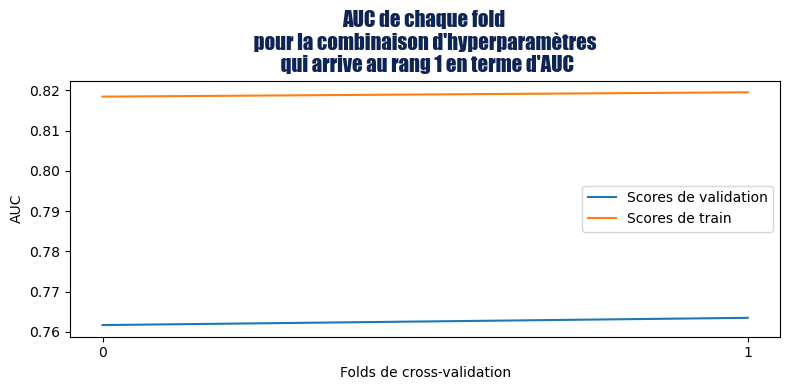

In [224]:
plot_auc_scores(best_auc_result_LGBM_2)

On constate une uniformité des résultats entre les 2 folds

In [225]:
result_lgbm_2=evaluate_model (X_train_r, y_train_r, X_test_r, y_test_r, best_model_lgbm_2)
result_lgbm_2

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


{'predicting_execution_time': 1.31,
 'auc_train': 0.8,
 'auc_test': 0.77,
 'optimal_threshold': 0.09,
 'f1_score_1_test': 0.27,
 'recall_1_test': 0.69,
 'accuracy_test': 0.7}

- Le LightGBM performe mieux après feature engineering et sélection de features, avec une AUC sur le train qui passe de 0.78 à 0.80 et sur le test de 0.74 à 0.77. Le modèle est capable de distinguer correctement les classes positives et négatives 77% du temps.
- L'overfitting de 3 points est acceptable. Le modèle généralise plutôt bien.
- Le seuil optimal qui permet de minimiser le coût métier est de 0.09
- A ce seuil optimal de 0.09, le recall de la classe 1 monte à 0.69 => cela signifie que le modèle détecte correctement 69% des instances de la classe 1. Ce rappel est raisonnablement bon, mais il y a encore 31% des instances de la classe 1 qui ne sont pas détectées (faux négatifs).

In [226]:
# Utiliser un échantillon de 10 lignes comme exemple d'entrée
input_example = X_train_r.sample(n=10, random_state=42)

In [227]:
# Création d'une nouvelle expérience MLflow
mlflow.set_experiment("MLflow Credit_Scoring - Projet_7")

# Commencer une session MLflow
with mlflow.start_run():
    # Log les hyperparameters que j'ai déclarés au dessus
    mlflow.log_params(best_params_lgbm_2)

    # Log les métriques
    
    mlflow.log_metric("optimal_threshold", result_lgbm_2['optimal_threshold'])

    mlflow.log_metric("recall_1_test", result_lgbm_2['recall_1_test'])
    mlflow.log_metric("f1_score_1_test", result_lgbm_2['f1_score_1_test'])
    mlflow.log_metric("accuracy du test", result_lgbm_2['accuracy_test'])
    
    mlflow.log_metric("auc_train", result_lgbm_2['auc_train'])
    mlflow.log_metric("auc_test", result_lgbm_2['auc_test'])
    
    mlflow.log_metric("temps_fit", training_execution_time)
    mlflow.log_metric("temps_predict", result_lgbm_2['predicting_execution_time'])

    
 
    

    # Définir un tag pour se rappeler l'objet de cette session
    mlflow.set_tag("Training Info", "LGBM after feature engineering and selection")

    # Infer the model signature
    signature = infer_signature(X_train_r, best_model_lgbm_2.predict(X_train_r)) # infer_signature génère automatiquement une "signature" 
                                                              # qui décrit les entrées et les sorties du modèle. 
                                                              # Cela inclut les types de données et les formats attendus par le modèle, 
                                                              # facilitant ainsi l'intégration et la réutilisation du modèle 
                                                              # dans différents environnements.

    
    # Log le model
    model_info = mlflow.sklearn.log_model(
        sk_model=best_model_lgbm_2.named_steps['model'], # le modèle
        artifact_path="lgbm_classifier_model", # le chemin où le modèle sera enregistré
        signature=signature, # la signature du modèle
        input_example=input_example, # un exemple d'input pour montrer comment invoquer le modèle
        registered_model_name="scoring-credit-lgbm_classifier", # nom sous lequel le modèle est enregistré dans le registre de modèles MLflow
    )


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


Registered model 'scoring-credit-lgbm_classifier' already exists. Creating a new version of this model...
2024/07/26 18:15:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: scoring-credit-lgbm_classifier, version 45
Created version '45' of model 'scoring-credit-lgbm_classifier'.


# 8 - Interprétation des résultats
----------


## 8.1 - Feature Importance

In [238]:
importances = best_model_lgbm_2.named_steps['model'].feature_importances_
features= X_train_r.columns

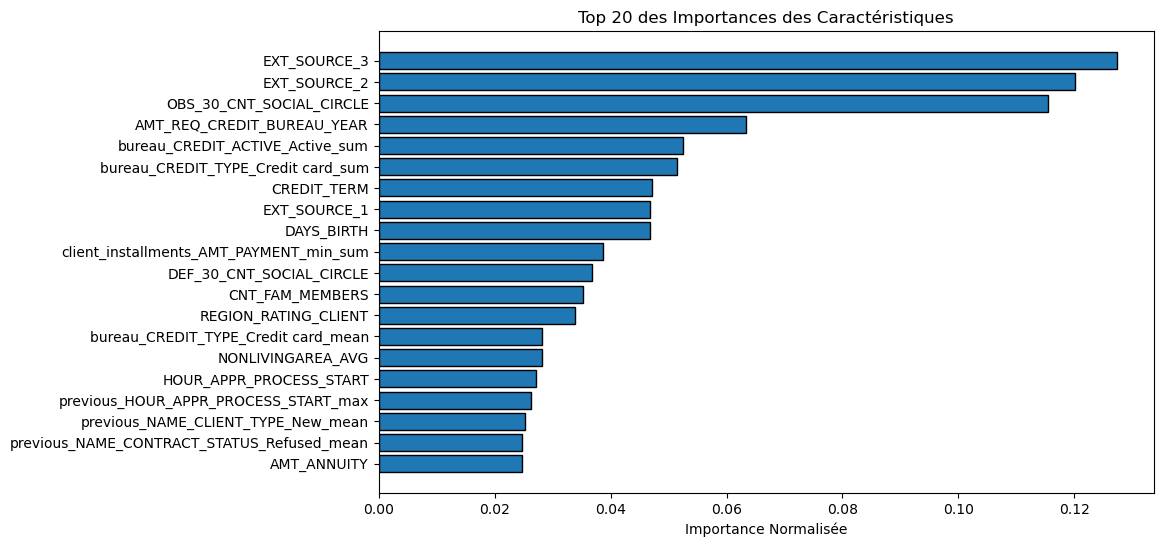

In [239]:
feature_importances_sorted=show_feature_importances(importances, features)

In [242]:
feature_importances_sorted.head(10)

,feature,importance,importance_normalized
0,EXT_SOURCE_3,267,0.127325
1,EXT_SOURCE_2,252,0.120172
2,OBS_30_CNT_SOCIAL_CIRCLE,242,0.115403
3,AMT_REQ_CREDIT_BUREAU_YEAR,133,0.063424
4,bureau_CREDIT_ACTIVE_Active_sum,110,0.052456
5,bureau_CREDIT_TYPE_Credit card_sum,108,0.051502
6,CREDIT_TERM,99,0.047210
7,EXT_SOURCE_1,98,0.046733
8,DAYS_BIRTH,98,0.046733
9,client_installments_AMT_PAYMENT_min_sum,81,0.038627


Parmi les 10 variables les + influentes, on retrouve :
- Les 3 variables de score normalisé provenant d'une source de données externe (EXT_SOURCE_3, EXT_SOURCE_2, EXT_SOURCE_1)
- 'OBS_30_CNT_SOCIAL_CIRCLE' :  nombre de fois où l'entourage social du client a eu des défauts de paiement dépassant de 30 jours l'échéance prévue.
- 'AMT_REQ_CREDIT_BUREAU_YEAR' : Nombre de demandes de renseignements au bureau de crédit concernant le client dans l'année précédant la demande
- 'CREDIT_TERM' : la durée du crédit (en mois)
- etc...

In [243]:
feature_importances_sorted.to_csv('feature_importances_sorted_lgbm_2.csv', index=False)

## 8.2 - Shap Values

### 8.2.1 - Interprétation globale du test

In [244]:
# on s'assure que le meilleur modèle est extrait de la pipeline
best_model=best_model_lgbm_2.named_steps['model']

In [245]:
# Initialisation de l'Explainer SHAP avec le meilleur modèle obtenu sur le jeu de données de test original
explainer = shap.Explainer(best_model)

In [246]:
# Calcul des valeurs SHAP sur les données de test
shap_values = explainer.shap_values(X_test_r)

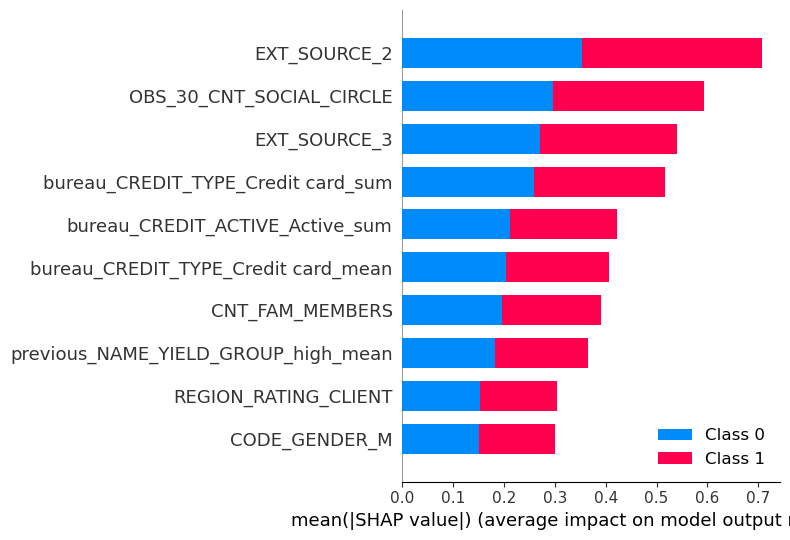

In [247]:
# Créer un graphique récapitulatif SHAP pour l'ensemble des données transformées
shap.summary_plot(shap_values, X_test_r, 
                  plot_type="bar",
                 max_display=10)

Si on regarde ce qui se passe pour la classe 1 :

In [248]:
shap_values_class1 = shap_values[1]

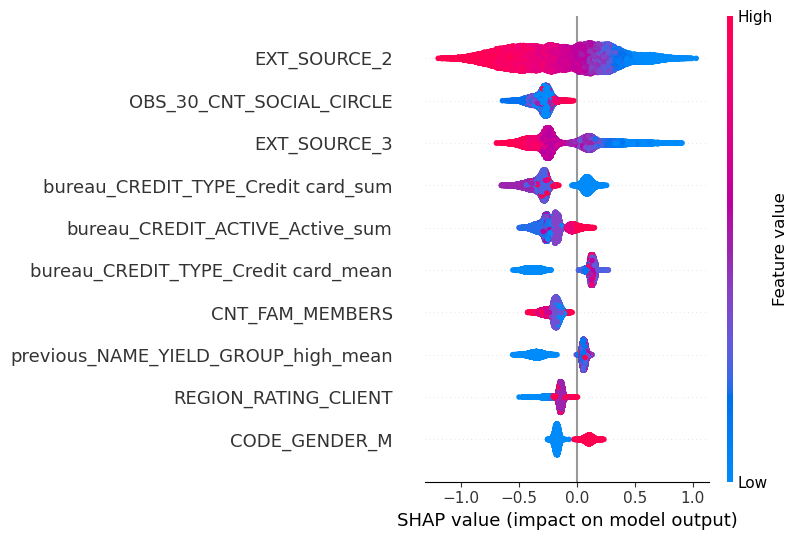

In [249]:
# Graphique récapitulatif SHAP pour la classe 1
shap.summary_plot(shap_values_class1, 
                  X_test_r, 
                  max_display=10)

Commentaires :
- Plus les variables EXT_SOURCE_2 et EXT_SOURCE_2 sont faibles, plus le client est risqué
- A l'inverse, plus l'entourage social du client a eu des défauts de paiement dépassant de 30 jours l'échéance prévue, plus le client est risqué ('OBS_30_CNT_SOCIAL_CIRCLE'), ce qui est logique.
- Les hommes semblent égalment plus risqué (CODE_GENDER_M)

### 8.2.2 - Interprétation locale

#### 8.2.2.1 - Reconstruction du test

In [268]:
# reconstruction du test
test_dataset = pd.concat([X_test_r, y_test_r.reset_index(drop=True), id_test_r.reset_index(drop=True)], axis=1)
# verif
test_dataset[test_dataset['SK_ID_CURR']==100002]

,EXT_SOURCE_1,CREDIT_TERM,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,client_installments_AMT_PAYMENT_min_sum,AMT_ANNUITY,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,...,client_installments_NUM_INSTALMENT_NUMBER_min_max,ORGANIZATION_TYPE_Business Entity Type 3,previous_NAME_CASH_LOAN_PURPOSE_XNA_sum,previous_CODE_REJECT_REASON_LIMIT_mean,previous_NAME_SELLER_INDUSTRY_Construction_mean,FLAG_DOCUMENT_16,NAME_INCOME_TYPE_Working,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,TARGET,SK_ID_CURR
17677,0.073068,0.377861,0.307542,0.155054,0.111161,0.964437,0.025738,0.090032,0.96475,0.583634,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,100002


In [269]:
# verif
train_reduced[train_reduced['SK_ID_CURR']==100002]

,EXT_SOURCE_1,CREDIT_TERM,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,client_installments_AMT_PAYMENT_min_sum,AMT_ANNUITY,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,...,client_installments_NUM_INSTALMENT_NUMBER_min_max,ORGANIZATION_TYPE_Business Entity Type 3,previous_NAME_CASH_LOAN_PURPOSE_XNA_sum,previous_CODE_REJECT_REASON_LIMIT_mean,previous_NAME_SELLER_INDUSTRY_Construction_mean,FLAG_DOCUMENT_16,NAME_INCOME_TYPE_Working,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,TARGET,SK_ID_CURR
0,0.083037,0.060749,0.262949,0.139376,9461,-637.0,175783.73,24700.5,-103.0,780.0,...,1.0,True,0.0,0.0,0.0,0,True,0.0,1,100002


In [270]:
# predict proba avec le best model
y_test_pred_proba = best_model_lgbm_2.predict_proba(X_test_r)[:, 1]

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


In [271]:
# Find the optimal threshold for cost function on the training data
thresholds = np.linspace(0, 1, 100)
costs = [calculate_cost_threshold(y_test_r, y_test_pred_proba, thr, cost_fn=10, cost_fp=1) for thr in thresholds]
optimal_threshold = round(thresholds[np.argmin(costs)],2) 

# Metrics at the optimal threshold
y_test_pred_opt = (y_test_pred_proba >= optimal_threshold).astype(int)

In [272]:
test_dataset['target_pred']=y_test_pred_opt
test_dataset['proba']=y_test_pred_proba

test_dataset[test_dataset['SK_ID_CURR']==100002]

,EXT_SOURCE_1,CREDIT_TERM,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,client_installments_AMT_PAYMENT_min_sum,AMT_ANNUITY,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,...,previous_NAME_CASH_LOAN_PURPOSE_XNA_sum,previous_CODE_REJECT_REASON_LIMIT_mean,previous_NAME_SELLER_INDUSTRY_Construction_mean,FLAG_DOCUMENT_16,NAME_INCOME_TYPE_Working,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,TARGET,SK_ID_CURR,target_pred,proba
17677,0.073068,0.377861,0.307542,0.155054,0.111161,0.964437,0.025738,0.090032,0.96475,0.583634,...,0.0,0.0,0.0,0.0,1.0,0.0,1,100002,1,0.240568


In [273]:
pd.crosstab(y_test_r, y_test_pred_opt, rownames=['Classes réelles'], colnames=['Classes prédites'])

Classes prédites,0,1
Classes réelles,,
0,39779,16775
1,1529,3420


In [274]:
print(classification_report(y_test_r, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56554
           1       0.17      0.69      0.27      4949

    accuracy                           0.70     61503
   macro avg       0.57      0.70      0.54     61503
weighted avg       0.90      0.70      0.77     61503



#### 8.2.2.2 - Interprétation d'un individu prédit en classe 1

In [275]:
test_dataset[test_dataset['target_pred']==1].head()

,EXT_SOURCE_1,CREDIT_TERM,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,client_installments_AMT_PAYMENT_min_sum,AMT_ANNUITY,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,...,previous_NAME_CASH_LOAN_PURPOSE_XNA_sum,previous_CODE_REJECT_REASON_LIMIT_mean,previous_NAME_SELLER_INDUSTRY_Construction_mean,FLAG_DOCUMENT_16,NAME_INCOME_TYPE_Working,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,TARGET,SK_ID_CURR,target_pred,proba
0,0.705732,0.889266,0.707479,0.000000,0.327396,0.957459,0.004421,0.199000,0.955852,0.576120,...,0.017241,0.00,0.0,0.0,0.0,0.0,0,384575,1,0.154152
2,0.547108,0.556254,0.621942,0.231648,0.587260,0.964326,0.011368,0.146227,0.863450,0.589233,...,0.051724,0.00,0.0,0.0,1.0,0.0,0,142232,1,0.163902
5,0.524898,0.836415,0.607166,0.116437,0.656201,0.908106,0.054768,0.057880,0.947296,0.575846,...,0.017241,0.00,0.0,0.0,0.0,0.0,0,362171,1,0.091823
7,0.524898,0.183830,0.014722,0.546890,0.186697,0.985485,0.022055,0.122868,0.809377,0.585332,...,0.017241,0.00,0.0,0.0,0.0,0.0,0,310328,1,0.403582
11,0.524898,0.265223,0.529907,0.270982,0.053495,0.954835,0.018286,0.036890,0.923682,0.948943,...,0.000000,0.25,0.0,0.0,0.0,0.0,1,120952,1,0.096540


In [276]:
test_dataset[test_dataset['SK_ID_CURR']==384575]

,EXT_SOURCE_1,CREDIT_TERM,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,client_installments_AMT_PAYMENT_min_sum,AMT_ANNUITY,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,...,previous_NAME_CASH_LOAN_PURPOSE_XNA_sum,previous_CODE_REJECT_REASON_LIMIT_mean,previous_NAME_SELLER_INDUSTRY_Construction_mean,FLAG_DOCUMENT_16,NAME_INCOME_TYPE_Working,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,TARGET,SK_ID_CURR,target_pred,proba
0,0.705732,0.889266,0.707479,0.0,0.327396,0.957459,0.004421,0.199,0.955852,0.57612,...,0.017241,0.0,0.0,0.0,0.0,0.0,0,384575,1,0.154152


In [262]:
specific_id = 384575
index=test_dataset[test_dataset['SK_ID_CURR']==specific_id].index[0]

In [263]:
individual_shap_values = shap_values[1][index]  # Choix de la classe positive 

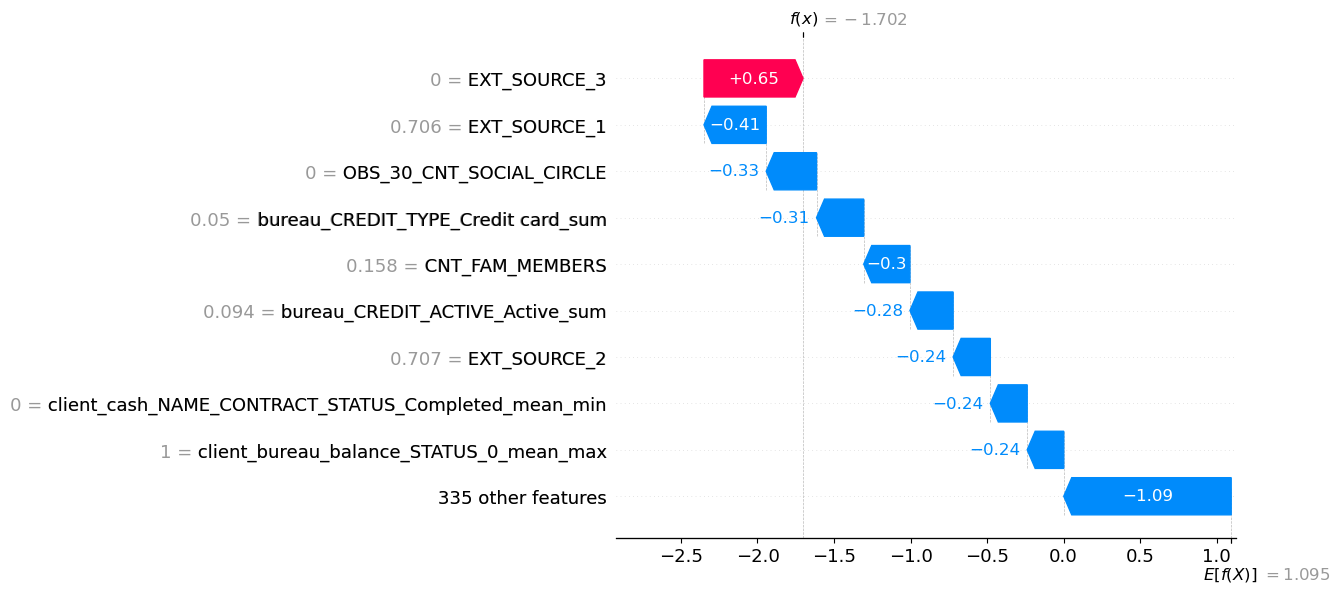

In [264]:
# Créer le graphique waterfall pour cet individu
shap.plots.waterfall(shap.Explanation(values=individual_shap_values,
                                      base_values=explainer.expected_value[1], # Assurez-vous de choisir la bonne valeur de base
                                      data=X_test_r.iloc[index],         # Données de l'individu à l'index 0
                                      feature_names=X_test_r.columns.tolist())) # Noms des caractéristiques



#### 8.2.2.3 - Interprétation d'un individu prédit en classe 0

In [265]:
test_dataset[test_dataset['target_pred']==0].head()

,EXT_SOURCE_1,CREDIT_TERM,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,client_installments_AMT_PAYMENT_min_sum,AMT_ANNUITY,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_ENDDATE_max,...,previous_NAME_CASH_LOAN_PURPOSE_XNA_sum,previous_CODE_REJECT_REASON_LIMIT_mean,previous_NAME_SELLER_INDUSTRY_Construction_mean,FLAG_DOCUMENT_16,NAME_INCOME_TYPE_Working,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,TARGET,SK_ID_CURR,target_pred,proba
1,0.444220,0.157447,0.497486,0.794687,0.410879,0.936300,0.197013,0.184591,0.899042,0.702708,...,0.120690,0.083333,0.0,0.0,0.0,0.0,0,214010,0,0.040213
3,0.524898,0.740962,0.811136,0.685538,0.684160,0.610205,0.000034,0.090962,0.252225,0.545527,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0,389171,0,0.054783
4,0.683325,0.287297,0.655778,0.710063,0.723675,0.938310,0.014431,0.055563,0.925736,0.594982,...,0.086207,0.000000,0.0,0.0,1.0,0.0,0,283617,0,0.052756
6,0.746486,0.053024,0.640892,0.599166,0.464092,0.980739,0.022055,0.090225,0.751198,0.564321,...,0.017241,0.000000,0.0,0.0,0.0,0.0,0,180689,0,0.040443
8,0.524898,0.214706,0.090684,0.706328,0.903439,0.908106,0.111500,0.128027,0.878850,0.583101,...,0.155172,0.000000,0.0,0.0,0.0,0.0,0,233043,0,0.067578


In [266]:
specific_id = 214010
index=test_dataset[test_dataset['SK_ID_CURR']==specific_id].index[0]

In [267]:
individual_shap_values = shap_values[0][index]  # Choix de la classe positive 

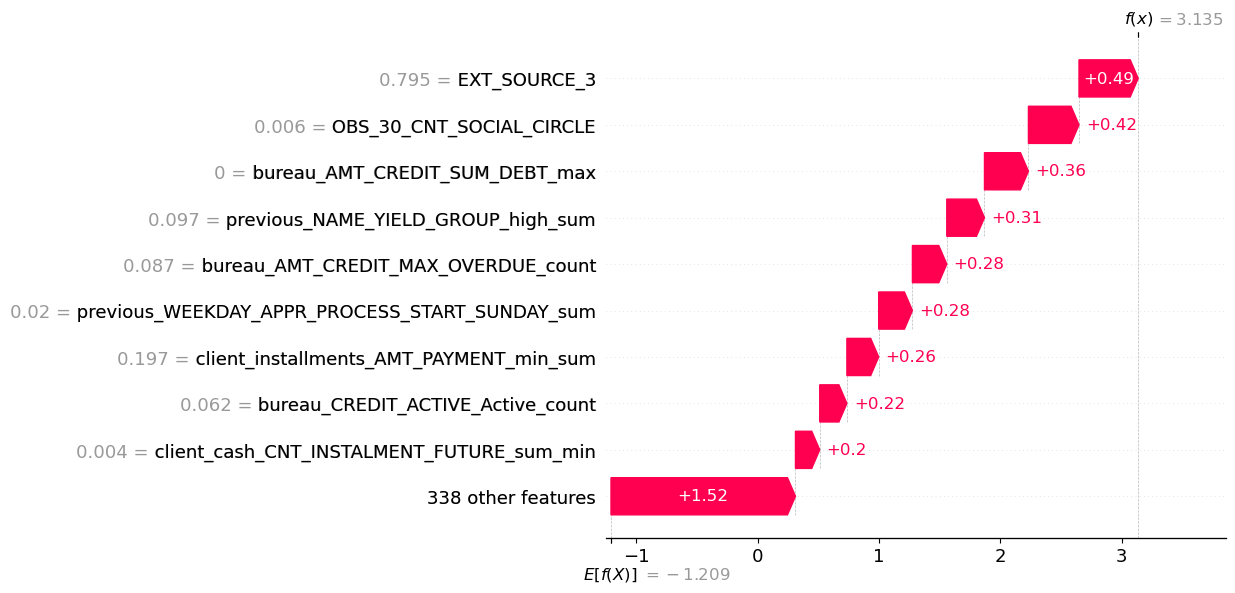

In [62]:
# Créer le graphique waterfall pour cet individu
shap.plots.waterfall(shap.Explanation(values=individual_shap_values,
                                      base_values=explainer.expected_value[0], # Assurez-vous de choisir la bonne valeur de base
                                      data=X_test_r.iloc[index],         # Données de l'individu à l'index 0
                                      feature_names=X_test_r.columns.tolist())) # Noms des caractéristiques


In [63]:
def generate_shap_waterfall(specific_id, shap_values, test_dataset, explainer, X_r):
    """
    Génère un graphique waterfall SHAP pour un individu spécifié par son ID.

    Parameters:
    - specific_id : int
        L'ID de l'individu pour lequel générer le graphique.
    - shap_values : list of numpy arrays
        Les valeurs SHAP pour les classes, typiquement [shap_values_class0, shap_values_class1].
    - test_dataset : DataFrame
        Le DataFrame contenant les identifiants des individus.
    - explainer : shap.Explainer
        L'explainer SHAP utilisé pour calculer les valeurs SHAP.
    - X_resampled : DataFrame
        Le DataFrame des données transformées (suréchantillonnées) sur lequel les valeurs SHAP ont été calculées.
    """
    # Trouver l'index de l'individu
    index = test_dataset[test_dataset['SK_ID_CURR'] == specific_id].index[0]

    # Prédire la classe pour l'individu
    predicted_class = test_dataset.loc[index, 'target_pred']

    # Obtenir les valeurs SHAP pour la classe prédite
    individual_shap_values = shap_values[predicted_class][index]

    # Création du graphique waterfall
    shap.plots.waterfall(shap.Explanation(values=individual_shap_values,
                                          base_values=explainer.expected_value[predicted_class],
                                          data=X_r.iloc[index],
                                          feature_names=X_r.columns.tolist()))
    plt.show()


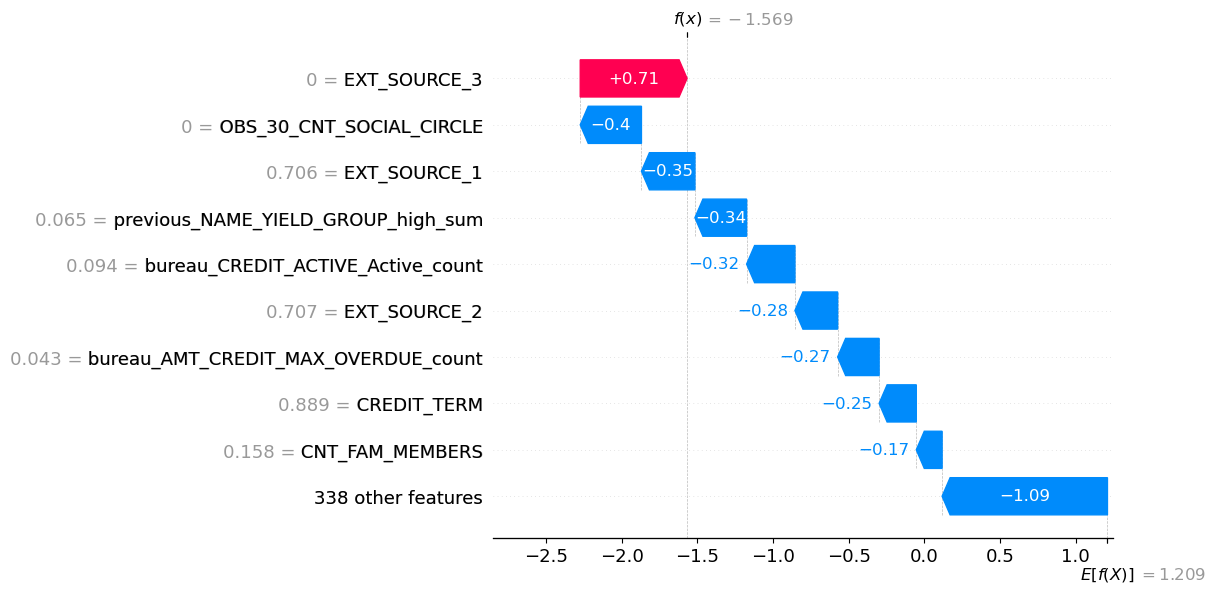

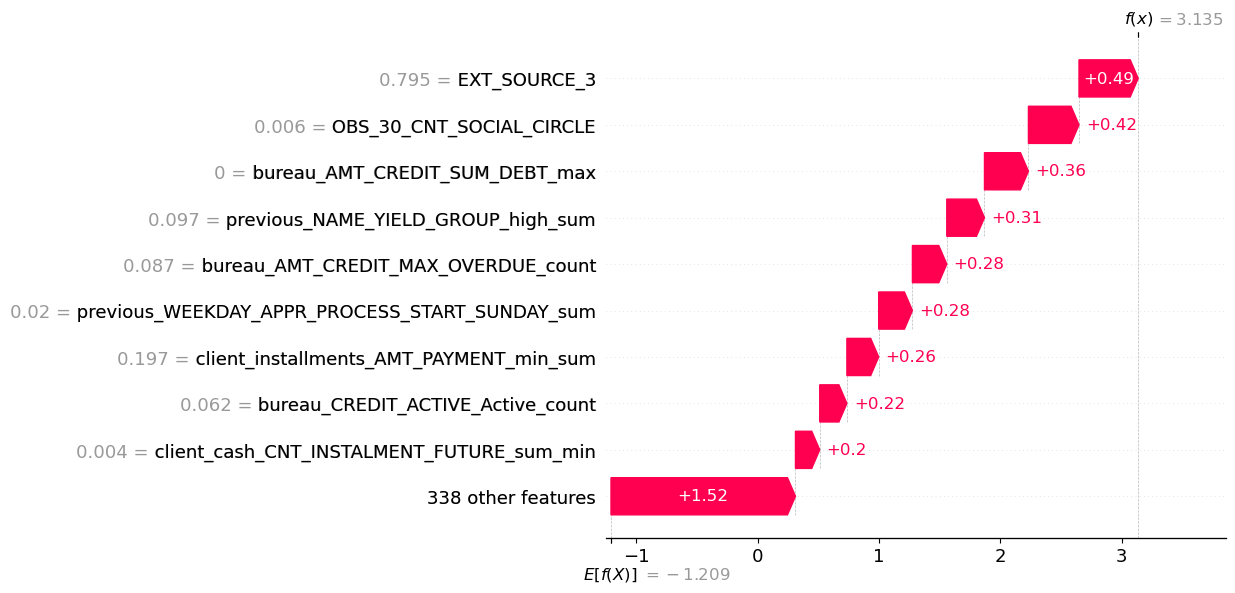

In [64]:
# Pour un individu prédit en classe 1
generate_shap_waterfall(384575, shap_values, test_dataset, explainer, X_test_r)

# Pour un individu prédit en classe 0
generate_shap_waterfall(214010, shap_values, test_dataset, explainer, X_test_r)
